# Review Tool Calls

!!! tip "Prerequisites"

    This guide assumes familiarity with the following concepts:

    * [Tool calling](https://js.langchain.com/docs/concepts/tool_calling/)
    * [Human-in-the-loop](/langgraphjs/concepts/human_in_the_loop)
    * [LangGraph Glossary](/langgraphjs/concepts/low_level)      

Human-in-the-loop (HIL) interactions are crucial for [agentic systems](https://langchain-ai.github.io/langgraphjs/concepts/agentic_concepts/#human-in-the-loop). A common pattern is to add some human in the loop step after certain tool calls. These tool calls often lead to either a function call or saving of some information. Examples include:

- A tool call to execute SQL, which will then be run by the tool
- A tool call to generate a summary, which will then be saved to the State of the graph

Note that using tool calls is common **whether actually calling tools or not**.

There are typically a few different interactions you may want to do here:

1. Approve the tool call and continue
2. Modify the tool call manually and then continue
3. Give natural language feedback, and then pass that back to the agent instead of continuing

We can implement these in LangGraph using the [`interrupt()`](/langgraphjs/reference/functions/langgraph.interrupt-1.html) function. `interrupt` allows us to stop graph execution to collect input from a user and continue execution with collected input:

```typescript
function humanReviewNode(state: typeof GraphAnnotation.State) {
  // this is the value we'll be providing via new Command({ resume: <human_review> })
  const humanReview = interrupt({
    question: "Is this correct?",
    // Surface tool calls for review
    tool_call,
  });

  const [reviewAction, reviewData] = humanReview;

  // Approve the tool call and continue
  if (reviewAction === "continue") {
    return new Command({ goto: "run_tool" });
  }
  
  // Modify the tool call manually and then continue
  if (reviewAction === "update") {
    const updatedMsg = getUpdatedMsg(reviewData);
    return new Command({ goto: "run_tool", update: { messages: [updatedMsg] } });
  }
  
  // Give natural language feedback, and then pass that back to the agent
  if (reviewAction === "feedback") {
    const feedbackMsg = getFeedbackMsg(reviewData);
    return new Command({ goto: "call_llm", update: { messages: [feedbackMsg] } });
  }
  
  throw new Error("Unreachable");
}
```


## Setup

First we need to install the packages required

```bash
npm install @langchain/langgraph @langchain/anthropic @langchain/core
```

Next, we need to set API keys for Anthropic (the LLM we will use)

```bash
export ANTHROPIC_API_KEY=your-api-key
```

Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

```bash
export LANGCHAIN_TRACING_V2="true"
export LANGCHAIN_CALLBACKS_BACKGROUND="true"
export LANGCHAIN_API_KEY=your-api-key
```

## Simple Usage

Let's set up a very simple graph that facilitates this.
First, we will have an LLM call that decides what action to take.
Then we go to a human node. This node actually doesn't do anything - the idea is that we interrupt before this node and then apply any updates to the state.
After that, we check the state and either route back to the LLM or to the correct tool.

Let's see this in action!

In [14]:
import {
  MessagesAnnotation,
  StateGraph,
  START,
  END,
  MemorySaver,
  Command,
  interrupt
} from "@langchain/langgraph";
import { ChatAnthropic } from "@langchain/anthropic";
import { tool } from '@langchain/core/tools';
import { z } from 'zod';
import { AIMessage, ToolMessage } from '@langchain/core/messages';
import { ToolCall } from '@langchain/core/messages/tool';

const weatherSearch = tool((input: { city: string }) => {
    console.log("----");
    console.log(`Searching for: ${input.city}`);
    console.log("----");
    return "Sunny!";
}, {
    name: 'weather_search',
    description: 'Search for the weather',
    schema: z.object({
        city: z.string()
    })
});

const model = new ChatAnthropic({ 
    model: "claude-3-5-sonnet-latest"
}).bindTools([weatherSearch]);

const callLLM = async (state: typeof MessagesAnnotation.State) => {
    const response = await model.invoke(state.messages);
    return { messages: [response] };
};

const humanReviewNode = async (state: typeof MessagesAnnotation.State): Promise<Command> => {
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    const toolCall = lastMessage.tool_calls![lastMessage.tool_calls!.length - 1];

    const humanReview = interrupt<
      {
        question: string;
        toolCall: ToolCall;
      },
      {
        action: string;
        data: any;
      }>({
        question: "Is this correct?",
        toolCall: toolCall
      });

    const reviewAction = humanReview.action;
    const reviewData = humanReview.data;

    if (reviewAction === "continue") {
        return new Command({ goto: "run_tool" });
    }
    else if (reviewAction === "update") {
        const updatedMessage = {
            role: "ai",
            content: lastMessage.content,
            tool_calls: [{
                id: toolCall.id,
                name: toolCall.name,
                args: reviewData
            }],
            id: lastMessage.id
        };
        return new Command({ goto: "run_tool", update: { messages: [updatedMessage] } });
    }
    else if (reviewAction === "feedback") {
        const toolMessage = new ToolMessage({
          name: toolCall.name,
          content: reviewData,
          tool_call_id: toolCall.id
        })
        return new Command({ goto: "call_llm", update: { messages: [toolMessage] }});
    }
    throw new Error("Invalid review action");
};

const runTool = async (state: typeof MessagesAnnotation.State) => {
    const newMessages: ToolMessage[] = [];
    const tools = { weather_search: weatherSearch };
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    const toolCalls = lastMessage.tool_calls!;

    for (const toolCall of toolCalls) {
        const tool = tools[toolCall.name as keyof typeof tools];
        const result = await tool.invoke(toolCall.args);
        newMessages.push(new ToolMessage({
            name: toolCall.name,
            content: result,
            tool_call_id: toolCall.id
        }));
    }
    return { messages: newMessages };
};

const routeAfterLLM = (state: typeof MessagesAnnotation.State): typeof END | "human_review_node" => {
    const lastMessage = state.messages[state.messages.length - 1] as AIMessage;
    if (!lastMessage.tool_calls?.length) {
        return END;
    }
    return "human_review_node";
};

const workflow = new StateGraph(MessagesAnnotation)
    .addNode("call_llm", callLLM)
    .addNode("run_tool", runTool)
    .addNode("human_review_node", humanReviewNode, {
      ends: ["run_tool", "call_llm"]
    })
    .addEdge(START, "call_llm")
    .addConditionalEdges(
        "call_llm",
        routeAfterLLM,
        ["human_review_node", END]
    )
    .addEdge("run_tool", "call_llm");

const memory = new MemorySaver();

const graph = workflow.compile({ checkpointer: memory });

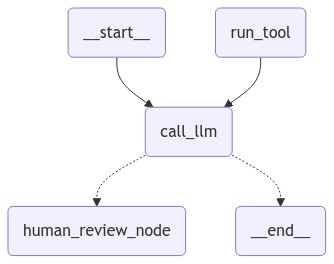

In [15]:
import * as tslab from "tslab";

const drawableGraph = graph.getGraph();
const image = await drawableGraph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

await tslab.display.png(new Uint8Array(arrayBuffer));

## Example with no review

Let's look at an example when no review is required (because no tools are called)

In [16]:
let inputs = { messages: [{ role: "user", content: "hi!" }] };
let config = { configurable: { thread_id: "1" }, streamMode: "values" as const };

let stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
hi!
================================ ai Message (1) =================================
Hello! I'm here to help you. I can assist you with checking the weather for different cities. Would you like to know the weather for a specific location? Just let me know which city you're interested in and I'll look that up for you.


If we check the state, we can see that it is finished, since there are no next steps to take:

In [17]:
let state = await graph.getState(config);
console.log(state.next);

[]


## Example of approving tool

Let's now look at what it looks like to approve a tool call

In [18]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "2" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01PTn9oqTP6EdFabfhfvELuy',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]


If we now check, we can see that it is waiting on human review

In [19]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To approve the tool call, we can just continue the thread with no edits. To do so, we need to let `human_review_node` know what value to use for the `human_review` variable we defined inside the node. We can provide this value by invoking the graph with a `new Command({ resume: <human_review> })` input.  Since we're approving the tool call, we'll provide `resume` value of `{ action: "continue" }` to navigate to `run_tool` node:

In [20]:
import { Command } from "@langchain/langgraph";

for await (const event of await graph.stream(
  new Command({ resume: { action: "continue" } }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}

================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01PTn9oqTP6EdFabfhfvELuy',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
----
Searching for: San Francisco
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
It's sunny in San Francisco right now!


## Edit Tool Call

Let's now say we want to edit the tool call. E.g. change some of the parameters (or even the tool called!) but then execute that tool.

In [21]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "3" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]


If we now check, we can see that it is waiting on human review

In [22]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To edit the tool call, we will use `Command` with a different resume value of `{ action: "update", data: <tool call args> }`. This will do the following:

* combine existing tool call with user-provided tool call arguments and update the existing AI message with the new tool call
* navigate to `run_tool` node with the updated AI message and continue execution

In [23]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "update",
      data: { city: "San Francisco" }
    }
  }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}


================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'Let me check the weather in San Francisco for you.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01T7ykQ45XyGpzRB7MkPtSAE',
    name: 'weather_search',
    input: { city: 'San Francisco' }
  }
]
----
Searching for: San Francisco
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
It's sunny in San Francisco right now!


## Give feedback to a tool call

Sometimes, you may not want to execute a tool call, but you also may not want to ask the user to manually modify the tool call. In that case it may be better to get natural language feedback from the user. You can then insert these feedback as a mock **RESULT** of the tool call.

There are multiple ways to do this:

1. You could add a new message to the state (representing the "result" of a tool call)
2. You could add TWO new messages to the state - one representing an "error" from the tool call, other HumanMessage representing the feedback

Both are similar in that they involve adding messages to the state. The main difference lies in the logic AFTER the `human_node` and how it handles different types of messages.

For this example we will just add a single tool call representing the feedback. Let's see this in action!

In [24]:
inputs = { messages: [{ role: "user", content: "what's the weather in SF?" }] };
config = { configurable: { thread_id: "4" }, streamMode: "values" as const };

stream = await graph.stream(inputs, config);

for await (const event of stream) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ human Message (1) =================================
what's the weather in SF?
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "I'll help you check the weather in San Francisco."
  },
  {
    type: 'tool_use',
    id: 'toolu_014cwxD65wDwQdNg6xqsticF',
    name: 'weather_search',
    input: { city: 'SF' }
  }
]


If we now check, we can see that it is waiting on human review

In [25]:
state = await graph.getState(config);
console.log(state.next);

[ 'human_review_node' ]


To give feedback about the tool call, we will use `Command` with a different resume value of `{ action: "feedback", data: <feedback string> }`. This will do the following:

* create a new tool message that combines existing tool call from LLM with the with user-provided feedback as content
* navigate to `call_llm` node with the updated tool message and continue execution

In [26]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "feedback",
      data: "User requested changes: use <city, country> format for location"
    }
  }),
  config
)) {
  const recentMsg = event.messages[event.messages.length - 1];
  console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
  console.log(recentMsg.content);
}


================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: "I'll help you check the weather in San Francisco."
  },
  {
    type: 'tool_use',
    id: 'toolu_014cwxD65wDwQdNg6xqsticF',
    name: 'weather_search',
    input: { city: 'SF' }
  }
]
================================ tool Message (1) =================================
User requested changes: use <city, country> format for location
================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the error. Let me search again with the proper format.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Jnm7sSZsiwv65YM4KsvfXk',
    name: 'weather_search',
    input: { city: 'San Francisco, USA' }
  }
]


We can see that we now get to another breakpoint - because it went back to the model and got an entirely new prediction of what to call. Let's now approve this one and continue.

In [27]:
state = await graph.getState(config);
console.log(state.next);


[ 'human_review_node' ]


In [28]:
for await (const event of await graph.stream(
  new Command({
    resume: {
      action: "continue",
    }
  }),
  config
)) {
    const recentMsg = event.messages[event.messages.length - 1];
    console.log(`================================ ${recentMsg._getType()} Message (1) =================================`)
    console.log(recentMsg.content);
}

================================ ai Message (1) =================================
[
  {
    type: 'text',
    text: 'I apologize for the error. Let me search again with the proper format.'
  },
  {
    type: 'tool_use',
    id: 'toolu_01Jnm7sSZsiwv65YM4KsvfXk',
    name: 'weather_search',
    input: { city: 'San Francisco, USA' }
  }
]
----
Searching for: San Francisco, USA
----
================================ tool Message (1) =================================
Sunny!
================================ ai Message (1) =================================
The weather in San Francisco is currently sunny!
